In [1]:
%matplotlib inline

In [2]:
# Import python modules
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import modelling_utils
import plotting_functions as plots
import warnings
warnings.filterwarnings('ignore')

In [33]:
# The actual inversoin data are stored on disk as netcdf files. NetCDF is an efficient format for storing
# self-describing containerised data.
# The implementation of netcdf for AEM line data was done by Alex Ip using his geophys_utils package.
# https://github.com/GeoscienceAustralia/geophys_utils/tree/master/geophys_utils
root = r"C:\Users\symin\OneDrive\Documents\GA\AEM\LCI"

infile = os.path.join(root, "Injune_lci_MGA55.nc")

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))


# Directory in which the grids are located
infile = r"C:\Users\symin\OneDrive\Documents\GA\AEM\LCI\grids\Injune_layer_grids.p"

# Run function
lci.load_lci_layer_grids_from_pickle(infile)

# Create polylines
lci.create_flightline_polylines()

In [4]:
# Path to netcdf file
infile = r"C:\Users\symin\OneDrive\Documents\GA\AEM\rjmcmc\Injune_petrel_rjmcmc_pmaps.nc"


# Create instance
rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                             inversion_type = 'stochastic',
                             netcdf_dataset = netCDF4.Dataset(infile))

In [38]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'data_residual', 'depth_of_investigation']


# Define the resolution of the sections
xres, yres = 40., 5.

# We will use the lines from the rj

lines = rj.data['line'][:]

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\Temp\Injune_hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


#lci.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

lci.load_sections_from_file(hdf5_dir, grid_vars, lines = lines)

In [39]:

# Grid the rj sections

# Assign the lci variables to grid
grid_vars = ['conductivity_p10', 'conductivity_p50', 'conductivity_p90', 'interface_depth_histogram']

# Define the resolution of the sections
xres, yres = 100., 2.

# We will use the lines from the rj

lines = np.unique(rj.data['line'][:].astype('int'))

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\Temp\Injune_hdf5_rj"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

#rj.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

rj.load_sections_from_file(hdf5_dir, grid_vars, lines = lines)


In [40]:
lci.layer_grids

{'Layer_1': {'conductivity': array([[       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         [       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         [       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         ...,
         [       nan,        nan,        nan, ..., 0.08656207, 0.06002748,
          0.01477348],
         [       nan,        nan,        nan, ..., 0.08587363, 0.04862505,
          0.00402901],
         [       nan,        nan,        nan, ..., 0.06155799, 0.02616558,
          0.00320392]], dtype=float32),
  'depth_from': 0.0,
  'depth_to': 5.0},
 'Layer_2': {'conductivity': array([[       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         [       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         [       nan,        nan,        nan, ...,        nan,        nan,
               

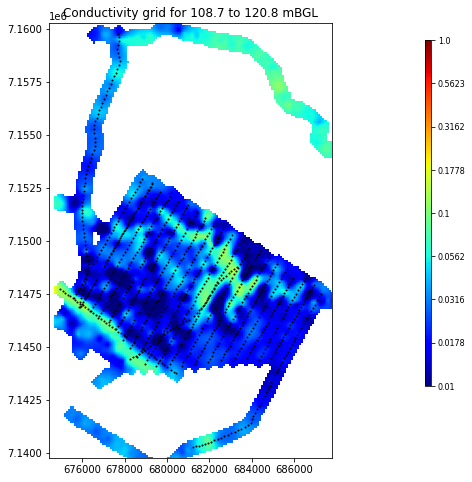

In [41]:


# In this notebook, standard plot key word arguments are passed to the plotting function as a python dictionary

# Here we explain each variable. Feel free to change and regenerate the plot
plot_args = {'Layer_number': 15, # Which AEM layer grid to plot from layer 1 (shallowest) to 30 (deepest)
             "figsize": (8,8), # The figure size in inches
             "vmin": 0.01, "vmax": 1., # The maximum and minimum conductivities in (S/m) for the grid colourstretch
             "point_size": 1, "point_colour": 'black', # Size and colour of the scatter plot points
             'colour_stretch': 'jet', # See matplotlib colourstretches
             'buffer': 500.} # The plot boundary will be buffered around the outer most scatter points.

plt.close('all')
# Do some plotting

fig, ax, cax = plots.AEM_baseplot(rj, lci, plot_args = plot_args)


plt.show()



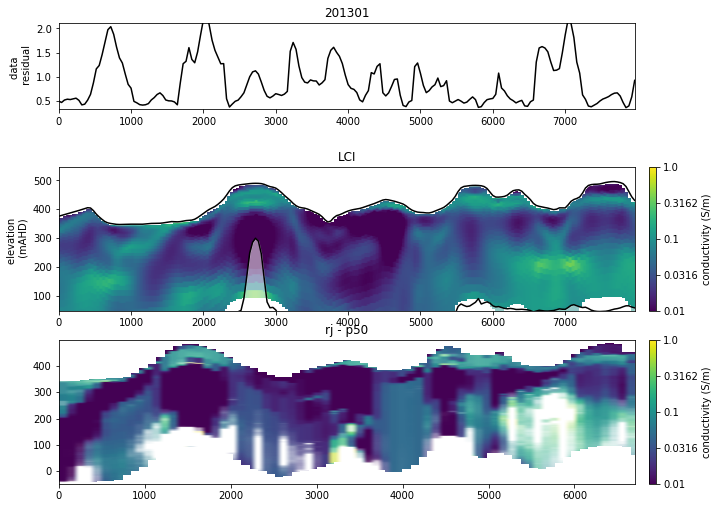

In [42]:
# Section plot

# Composite plot
plt.close('all')
fig = plt.figure(figsize = (10,8))

# Add two axes for the data misfit and the conductivity
#
ax1 = fig.add_axes([0.1, 0.75, 0.8, 0.15])
ax2 = fig.add_axes([0.1, 0.4, 0.8, 0.25], sharex = ax1)
ax3 = fig.add_axes([0.1, 0.1, 0.8, 0.25])

# Add a color
cbar_ax2 = fig.add_axes([0.92, 0.4, 0.01, 0.25])
cbar_ax3 = fig.add_axes([0.92, 0.1, 0.01, 0.25])

panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                      },
                     {'max_depth': 300.,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.01,
                      'vmax': 1.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'},
                     {'max_depth': 300.,
                      'shade_doi': False,
                      'colourbar': False,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.01,
                      'vmax': 1.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'}]

# define your line
line = lines[8]

res = plots.plot_single_line(ax1, lci.section_data[line],
                                   'data_residual', panel_kwargs[0])

lci_section = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                           panel_kwargs[1])


vmin, vmax = panel_kwargs[2]['vmin'], panel_kwargs[2]['vmax']
cmap = panel_kwargs[2]['cmap']


colours = plots.array2rgba(rj.section_data, line, vmin, vmax, cmap,
                           upper_threshold = 0.9, lower_threshold = 0.1)

extent = (rj.section_data[line]['grid_distances'][0], rj.section_data[line]['grid_distances'][-1],
          rj.section_data[line]['grid_elevations'][-1], rj.section_data[line]['grid_elevations'][0])


rj_section = ax3.imshow(colours, aspect = 'auto',extent = extent,
                        vmin = np.log10(vmin), vmax= np.log10(vmax),
                       cmap = cmap)


cb2 = fig.colorbar(lci_section, cax=cbar_ax2, orientation='vertical')

cbar_ax2.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])

cb2.set_label('conductivity (S/m)', fontsize=10)

cb3 = fig.colorbar(rj_section, cax=cbar_ax3, orientation='vertical')

cbar_ax3.set_yticklabels([round(10 ** x, 4) for x in cb3.get_ticks()])

cb3.set_label('conductivity (S/m)', fontsize=10)

ax1.set_title(str(line))
ax2.set_title('LCI')
ax3.set_title('rj - p50')

plt.show()


In [43]:
infile = r"C:\Users\symin\github\garjmcmctdem_utils\data\Surat_basin_AEM_interpretations.csv"

df_interp = pd.read_csv(infile, index_col=[0])

In [44]:
# Now we want to create a plot for each pmap showing the interpretation

def pmap_plot(D, pmap_kwargs, lci, figsize = (8,8), outfile = None):

    fig = plt.figure(figsize = figsize)

    ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.62])
    ax2 = fig.add_axes([0.45, 0.35, 0.2, 0.62])
    ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2])
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    ax5 = fig.add_axes([0.1, 0.18, 0.76, 0.05])
    ax6 = fig.add_axes([0.1, 0.05, 0.76, 0.13])
    ax7 = fig.add_axes([0.70, 0.78, 0.2, 0.2])
    cbar_ax1 = fig.add_axes([0.05, 0.29, 0.35, 0.01])
    cbar_ax2 = fig.add_axes([0.88, 0.05, 0.01, 0.2])

    # Plot probability map

    # ax1
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = pmap_kwargs['panel_1']['cmap'])

    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')

    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')

    ax1.set_ylim(pmap_kwargs['panel_1']['max_depth'],
                 pmap_kwargs['panel_1']['min_depth'])

    if pmap_kwargs['panel_1']['legend']:
        ax1.legend(loc = 3)

    # Ax 2
    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(ax1.get_ylim())

    if not pmap_kwargs['panel_2']['auto_xlim']:
        ax2.set_xlim(pmap_kwargs['panel_2']['pmin'],
                    pmap_kwargs['panel_2']['pmax'])

    if pmap_kwargs['panel_2']['legend']:
        ax2.legend()
    ax2.grid(which = 'both')


    # Ax 4
    sample = D['sample_no'][:]

    # Add the misfit
    for i in range(D['misfit'].shape[0]):

        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.01,1e4], 'k')
    ax4.set_xlim([1, D['misfit'].shape[1]])
    ax4.set_ylim(pmap_kwargs['panel_4']['misfit_min'],
                 pmap_kwargs['panel_4']['misfit_max'])

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")

    # Ax 5
    line = D['line']

    dist = D['lci_dist']

    res1 = plots.plot_single_line(ax5, D['lci_line'],
                                 'data_residual', pmap_kwargs['panel_5'])

    ax5.set_title('LCI conductivity section - ' + str(line))

    # Ax 6

    # Find distance along the lci section


    im2 = plots.plot_grid(ax6, D['lci_line'], 'conductivity',
                              panel_kwargs = pmap_kwargs['panel_6'])

    ax6.plot([dist, dist], [-1000, 1000], 'pink')
    ax6.set_xlabel("Distance along line (m)")

    ax5.set_xlim(dist - pmap_kwargs['panel_5']['buffer'],
                 dist + pmap_kwargs['panel_5']['buffer'])
    ax6.set_xlim(dist - pmap_kwargs['panel_6']['buffer'],
                 dist + pmap_kwargs['panel_6']['buffer'])

    # Ax7
    layer = pmap_kwargs['panel_7']['Layer_number']
    cond_grid = np.log10(lci.layer_grids['Layer_{}'.format(layer)]['conductivity'])

    im7 = ax7.imshow(cond_grid, extent = lci.layer_grids['bounds'],
                     cmap = pmap_kwargs['panel_7']['cmap'],
                     vmin = np.log10(pmap_kwargs['panel_7']['vmin']),
                     vmax =np.log10(pmap_kwargs['panel_7']['vmax']))

    ax7.set_xlim(D['easting'] - pmap_kwargs['panel_7']['buffer'],
                 D['easting'] + pmap_kwargs['panel_7']['buffer'])
    ax7.set_ylim(D['northing'] - pmap_kwargs['panel_7']['buffer'],
                 D['northing'] + pmap_kwargs['panel_7']['buffer'])
    ax7.plot(D['easting'],D['northing'],  'x', c = 'k')

    p1 = [lci.section_data[line]['easting'][0], lci.section_data[line]['easting'][-1]]
    p2 = [lci.section_data[line]['northing'][0], lci.section_data[line]['northing'][-1]]
    ax7.plot(p1, p2, 'k', linewidth = 0.5)
    ax7.set_title('LCI layer slice {}'.format(layer), fontsize=10)
    ax7.tick_params(axis='both', which='major', labelsize=8)
    ax7.tick_params(axis='both', which='minor', labelsize=8)

    # cbar axes
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)

    cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')

    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)

    ax_array = np.array([ax1, ax2, ax3, ax4, ax5, ax6, ax7])

    return fig, ax_array

In [45]:
# Next we define
pmap_kwargs = {# Panel 1 is the 2d histogram of conductivity and depth.
               # Counts are converted to probabilities
               'panel_1': {'min_depth': 0,
                           'max_depth': 300.,
                           'cmap': 'rainbow',
                           'legend': True},
               # Panel 2 is the change point histogram panel. This shows
               # where we are most likely to have layer boundaries.
              'panel_2': {'auto_xlim': True,
                          'pmin': 0.002,
                          'pmax': 5.,
                         'legend': False},
               # panel 3 is the interpolated surface grid described above.
              'panel_3': {},# nothing here for now
               # panel 4 shows the misfit for our MCMC chains. This plot shows
               # if our model has converged
              'panel_4': {'misfit_min': 0.01,
                          'misfit_max': 1e4},
               # panel 5 shows the lci misft for a section.
              'panel_5': {'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                         'buffer': 5000.},
               # panel 6 shows the lci conducivity Section
              'panel_6': {'title': 'LCI conductivity',
                      'max_depth': 300.,
                      'vmin': 0.001,
                      'vmax': 1,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)',
                       'buffer': 5000.,
                       'shade_doi': True},
               # panel 7 shows the gridded AEM conductivity.
              'panel_7': {'Layer_number': 4,
                          "vmin": 0.001, "vmax": 1.,
                          'cmap': 'jet',
                          'buffer': 5000.}}

rj point index is  0
Fidicial is  180366.0


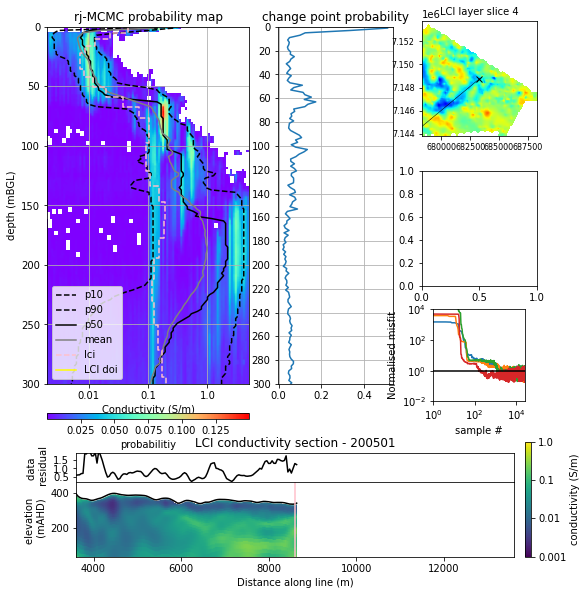

In [46]:

# Run the pmap interpretation again

plt.close('all')

# define our point from the points array using the index i
point_index = 0

# Extract the data from the netcdf data
D = netcdf_utils.extract_rj_sounding(rj, lci, point_index)

# print the poit index and fiducial for our reference
print("rj point index is ", point_index)
print("Fidicial is ", D['fiducial'])

# create the figure
fig, ax_array = pmap_plot(D, pmap_kwargs, lci)

# now lets plot on the interpretations
#TODO add the interpretations to the plots

# show the plot
plt.show()


In [37]:

lci.section_data

AttributeError: 'AEM_inversion' object has no attribute 'section_data'